In [8]:
!pip install keras_tcn

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Flatten
from tcn import TCN

from tensorflow.keras.layers import (
    Input, Dense, Dropout, Add, Conv1D,
    MaxPool1D, Bidirectional, LSTM, LayerNormalization
)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Add, Dense, LayerNormalization, Flatten, Masking, TimeDistributed
from tensorflow.keras import callbacks
from tcn import TCN

from sklearn.metrics import mean_absolute_error

from matplotlib.backends.backend_pdf import PdfPages
import joblib
import os

In [10]:
df_train = pd.read_csv('/kaggle/input/train-data/df_train_tahona_loss.csv')
df_test = pd.read_csv('/kaggle/input/train-data/df_test_tahona_loss.csv')
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# PARAMETERS

In [11]:
FEATURES = [
    "age",
    "temperature_min",
    "humidity_morning",
    "daily_weight",
    "daily_first_feed_intake",
    "daily_second_feed_intake",
    "daily_mortality",
    "total_meds",
    "birds_density",
    "season_encoded",
    "house_id",
    "farm_id"
]

TARGET = "daily_loss"
MAX_LEN = 31
PAD_VALUE = 0

numeric_features = [
    "age",
    "temperature_min",
    "humidity_morning",
    "daily_weight",
    "daily_first_feed_intake",
    "daily_second_feed_intake",
    "daily_mortality",
    "total_meds",
    "birds_density"
]

categorical_features = ["season_encoded", "house_id", "farm_id"]

# SCALERS

In [12]:
input_scaler = RobustScaler()
output_scaler = RobustScaler()

input_scaler.fit(df_train[numeric_features])
output_scaler.fit(df_train[[TARGET]])

RobustScaler()

# CREATE SEQUENCES 

In [13]:
def create_sequences(df, input_scaler, output_scaler,
                     numeric_features, categorical_features,
                     target, max_len=31, pad_value=0):

    all_X, all_y, all_masks = [], [], []

    for placement_id, group in df.groupby("placement_id"):
        group = group.sort_values('age').reset_index(drop=True)
        n_days = len(group)

        # Scale features
        numeric_scaled = input_scaler.transform(group[numeric_features])
        categorical_vals = group[categorical_features].values
        if categorical_vals.ndim == 1:
            categorical_vals = categorical_vals.reshape(-1, 1)

        X_full = np.concatenate([numeric_scaled, categorical_vals], axis=1)
        y_full = output_scaler.transform(group[[target]]).flatten()

        for i in range(n_days):
            seq_len = i + 1
            X_seq = X_full[:seq_len]

            # Pad input sequence
            if seq_len < max_len:
                pad = np.full((max_len - seq_len, X_full.shape[1]), pad_value)
                X_seq = np.vstack([pad, X_seq])

            # Mask: 1 for valid steps, 0 for padded steps
            mask = np.zeros(max_len)
            mask[max_len - seq_len:] = 1

            all_X.append(X_seq)
            all_y.append(y_full)
            all_masks.append(mask)

    return np.array(all_X), np.array(all_y), np.array(all_masks)

In [14]:
def shuffle_sequences(X, y, masks, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(X))
    return X[idx], y[idx], masks[idx]

# PREP DATA

In [15]:
print("\nCreating sequences...")
X_train, y_train, mask_train = create_sequences(
    df_train, input_scaler, output_scaler, numeric_features, categorical_features, TARGET, MAX_LEN, PAD_VALUE
)

X_test, y_test, mask_test = create_sequences(
    df_test, input_scaler, output_scaler, numeric_features, categorical_features, TARGET, MAX_LEN, PAD_VALUE
)

X_train, y_train, mask_train = shuffle_sequences(X_train, y_train, mask_train, seed=42)

print(f"\nTraining shapes: X={X_train.shape}, y={y_train.shape}, mask={mask_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, mask={mask_test.shape}")



Creating sequences...

Training shapes: X=(8711, 31, 12), y=(8711, 31), mask=(8711, 31)
Test shapes: X=(217, 31, 12), y=(217, 31), mask=(217, 31)


In [16]:
class SqueezeLastDim(layers.Layer):
    def call(self, x):
        return tf.squeeze(x, axis=-1)

In [17]:
# # -----------------------------
# # Attention Layer
# # -----------------------------
# class CausalWindowAttention(tf.keras.layers.Layer):
#     def __init__(self, window_size=3, **kwargs):
#         super().__init__(**kwargs)
#         self.window_size = window_size

#     def build(self, input_shape):
#         feature_dim = input_shape[-1]

#         self.W = self.add_weight(
#             shape=(feature_dim, feature_dim),
#             initializer="glorot_uniform",
#             trainable=True
#         )
#         self.b = self.add_weight(
#             shape=(feature_dim,),
#             initializer="zeros",
#             trainable=True
#         )
#         self.v = self.add_weight(
#             shape=(feature_dim, 1),
#             initializer="glorot_uniform",
#             trainable=True
#         )

#     def call(self, x, mask=None):
#         # x: (batch, time, features)
#         T = tf.shape(x)[1]
#         outputs = []

#         for t in range(x.shape[1]):  # static time dimension
#             start = max(0, t - self.window_size + 1)
#             window = x[:, start:t+1, :]  # (batch, ≤3, features)

#             # Attention scores
#             score = tf.tanh(tf.matmul(window, self.W) + self.b)
#             score = tf.matmul(score, self.v)  # (batch, ≤3, 1)

#             weights = tf.nn.softmax(score, axis=1)
#             context = tf.reduce_sum(weights * window, axis=1)

#             outputs.append(context)

#         return tf.stack(outputs, axis=1)  # (batch, time, features)


In [18]:
def visualize_predictions_given_days_new_masked(
    placement_ids_to_show, df_test, model,
    input_scaler, output_scaler,
    numeric_features, categorical_features,
    TARGET, MAX_LEN, PAD_VALUE,
    mask_test=None,
    given_days=[0, 10, 15, 20, 30]
):
    
    error_all = []

    for placement_id_to_show in placement_ids_to_show:
        placement_data = (
            df_test[df_test['placement_id'] == placement_id_to_show]
            .sort_values('age')
        )

        if len(placement_data) == 0:
            print(f"Placement {placement_id_to_show} not found in test set")
            continue

        true_loss = placement_data[TARGET].values
        n_days = len(true_loss)

        # Scale features
        numeric_scaled = input_scaler.transform(
            placement_data[numeric_features]
        )
        categorical_vals = placement_data[categorical_features].values
        if categorical_vals.ndim == 1:
            categorical_vals = categorical_vals.reshape(-1, 1)

        X_full = np.concatenate(
            [numeric_scaled, categorical_vals], axis=1
        )

        error = []

        for given_day in given_days:
            if given_day >= n_days - 1:
                error.append(np.nan)
                continue


            seq_len = min(given_day + 1, n_days)
            X_input = X_full[:seq_len]

            if seq_len < MAX_LEN:
                pad = np.full(
                    (MAX_LEN - seq_len, X_full.shape[1]),
                    PAD_VALUE
                )
                X_input = np.vstack([pad, X_input])

            X_input = X_input.reshape(1, MAX_LEN, X_full.shape[1])

            y_pred_scaled = model.predict(X_input, verbose=0)
            y_pred = output_scaler.inverse_transform(y_pred_scaled)
            y_pred = y_pred.reshape(-1)

            future_start = given_day + 1

            true_future = true_loss[future_start:]
            pred_future = y_pred[future_start:future_start + len(true_future)]

            cum_true_future = np.sum(true_future)
            cum_pred_future = np.sum(pred_future)

            diff = cum_true_future - cum_pred_future
            error.append(diff)

            plt.figure(figsize=(12, 6))
            plt.plot(true_loss, label="True")
            plt.plot(y_pred, label="Pred")

            plt.axvline(
                x=future_start - 1,
                color="red",
                linestyle="--",
                label="Prediction start"
            )
            
            plt.title(
                f"Placement {placement_id_to_show} | Given days: {given_day}\n"
                f"Future true sum: {int(cum_true_future)}, "
                f"Future pred sum: {int(cum_pred_future)}, "
                f"Diff: {int(diff)}"
            )

            plt.xlabel("Day")
            plt.ylabel("Daily Loss")
            plt.legend()
            plt.show()

        error_all.append(error)

    return error_all


In [19]:
test_placement_ids = df_test['placement_id'].unique()
placement_ids_to_show = test_placement_ids


In [20]:
def horizon_weighted_mae(y_true, y_pred, horizons):
    """
    Compute a weighted Mean Absolute Error across different horizons.
    Horizons are 0-indexed day positions (0 to MAX_LEN-1).
    """
    scores = []
    weights = []

    global_scale = np.mean(np.abs(y_true)) + 1e-8

    for h in horizons:
        yt = y_true[:, h]
        yp = y_pred[:, h]

        mae = np.mean(np.abs(yt - yp))
        nmae = mae / global_scale

        weight = h + 1
        scores.append(weight * nmae)
        weights.append(weight)

    return np.sum(scores) / np.sum(weights)


In [21]:
# def save_to_pdf(
#     placement_ids_to_show, df_test, model,
#     input_scaler, output_scaler,
#     numeric_features, categorical_features,
#     TARGET, MAX_LEN, PAD_VALUE,
#     mask_test=None,
#     given_days=[0, 10, 15, 20, 30],
#     pdf_path="predictions.pdf"
# ):
#     """
#     Visualize and save predictions for multiple placements in a PDF.
#     Only calculates cumulative difference for future days (beyond given_day).
#     """
#     error_all = []

#     with PdfPages(pdf_path) as pdf:
#         for placement_id_to_show in placement_ids_to_show:
#             placement_data = (
#                 df_test[df_test['placement_id'] == placement_id_to_show]
#                 .sort_values('age')
#             )

#             if len(placement_data) == 0:
#                 print(f"Placement {placement_id_to_show} not found in test set")
#                 continue

#             true_loss = placement_data[TARGET].values
#             n_days = len(true_loss)

#             # Scale numeric features
#             numeric_scaled = input_scaler.transform(
#                 placement_data[numeric_features]
#             )

#             # Combine with categorical features
#             categorical_vals = placement_data[categorical_features].values
#             if categorical_vals.ndim == 1:
#                 categorical_vals = categorical_vals.reshape(-1, 1)

#             X_full = np.concatenate([numeric_scaled, categorical_vals], axis=1)

#             error = []

#             for given_day in given_days:
#                 if given_day >= n_days - 1:
#                     error.append(np.nan)
#                     continue

#                 # ------------------------
#                 # Build input
#                 # ------------------------
#                 seq_len = min(given_day + 1, n_days)
#                 X_input = X_full[:seq_len]

#                 if seq_len < MAX_LEN:
#                     pad = np.full(
#                         (MAX_LEN - seq_len, X_full.shape[1]),
#                         PAD_VALUE
#                     )
#                     X_input = np.vstack([pad, X_input])

#                 X_input = X_input.reshape(1, MAX_LEN, X_full.shape[1])

#                 # ------------------------
#                 # Predict
#                 # ------------------------
#                 y_pred_scaled = model.predict(X_input, verbose=0)
#                 y_pred = output_scaler.inverse_transform(y_pred_scaled).flatten()
#                 y_pred = np.round(y_pred).astype(int)  # Round to integer counts

#                 # ------------------------
#                 # FUTURE-ONLY difference
#                 # ------------------------
#                 future_start = given_day + 1
#                 true_future = true_loss[future_start:]
#                 pred_future = y_pred[future_start:future_start + len(true_future)]

#                 cum_true_future = np.sum(true_future)
#                 cum_pred_future = np.sum(pred_future)
#                 diff = cum_true_future - cum_pred_future
#                 error.append(diff)

#                 # ------------------------
#                 # Plot
#                 # ------------------------
#                 fig, ax = plt.subplots(figsize=(12, 6))
#                 ax.plot(true_loss, label="True")
#                 ax.plot(y_pred, label="Pred")
#                 ax.axvline(
#                     x=future_start - 1,
#                     color="red",
#                     linestyle="--",
#                     label="Prediction start"
#                 )

#                 ax.set_title(
#                     f"Placement {placement_id_to_show} | Given days: {given_day}\n"
#                     f"Future true sum: {cum_true_future}, "
#                     f"Future pred sum: {cum_pred_future}, "
#                     f"Diff: {diff}"
#                 )
#                 ax.set_xlabel("Day")
#                 ax.set_ylabel("Daily Loss")
#                 ax.legend()
#                 ax.grid(True)

#                 pdf.savefig(fig)  # Save current figure to PDF
#                 plt.close(fig)    # Close the figure to free memory

#             error_all.append(error)

#     print(f"All plots saved to {pdf_path}")
#     return error_all


# Vector Quatizer

In [22]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta
        self.embeddings = self.add_weight(
            name="embeddings_vqvae",
            shape=(self.embedding_dim, self.num_embeddings),
            initializer=tf.random_uniform_initializer(),
            trainable=True
        )

    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

# Model

In [23]:
def build_lstm_tcn_hybrid_model_1(input_shape, PAD_VALUE, num_vq_embeddings=64, vq_beta=0.25):
    inputs = Input(shape=input_shape)

    # Mask padded values
    x = layers.Masking(mask_value=PAD_VALUE)(inputs)

    # TCN backbone
    tcn_out = TCN(
        nb_filters=64,
        kernel_size=4,
        nb_stacks=2,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        return_sequences=True,
        use_skip_connections=True,
        activation='elu'
    )(x)
    tcn_out = LayerNormalization()(tcn_out)

    # LSTM branch
    lstm_out = LSTM(64, return_sequences=True)(tcn_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)

    # Residual connection
    x = Add()([lstm_out, tcn_out])

    # Direct Dense branch
    x_direct = TimeDistributed(Dense(128, activation='elu'))(x)
    out_direct = TimeDistributed(Dense(1, activation='linear'))(x_direct)
    out_direct = SqueezeLastDim()(out_direct)

    # VQ branch
    x_vq = VectorQuantizer(num_embeddings=num_vq_embeddings, embedding_dim=x.shape[-1], beta=vq_beta)(x)
    x_vq = LayerNormalization()(x_vq)
    x_vq = TimeDistributed(Dense(128, activation='elu'))(x_vq)
    out_vq = TimeDistributed(Dense(1, activation='linear'))(x_vq)
    out_vq = SqueezeLastDim()(out_vq)

    # Average both branches
    outputs = layers.Average()([out_direct, out_vq])

    model = Model(inputs, outputs)
    return model


In [25]:
n_features = X_train.shape[2]

model_hybrid = build_lstm_tcn_hybrid_model_1(input_shape=(MAX_LEN, n_features), PAD_VALUE=PAD_VALUE)
model_hybrid.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 31, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 31, 12)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tcn (TCN)           │ (None, 31, 64)    │    316,480 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 31, 64)    │        128 │ tcn[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 31, 64)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 31, 64)    │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 31, 64)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vector_quantizer    │ (None, 31, 64)    │      4,096 │ add[0][0]         │
│ (VectorQuantizer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 64)    │        128 │ vector_quantizer… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 31, 128)   │      8,320 │ add[0][0]         │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 31, 128)   │      8,320 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 31, 1)     │        129 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 31, 1)     │        129 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_last_dim    │ (None, 31)        │          0 │ time_distributed… │
│ (SqueezeLastDim)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_last_dim_1  │ (None, 31)        │          0 │ time_distributed… │
│ (SqueezeLastDim)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 31)        │          0 │ squeeze_last_dim… │
│                     │                   │            │ squeeze_last_dim… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,778 (1.54 MB)

 Trainable params: 403,778 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

# Setup

In [28]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_hybrid.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=['mae']
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [29]:
history_hybrid = model_hybrid.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 1.8993 - mae: 0.7331 - val_loss: 1.8847 - val_mae: 0.6397 - learning_rate: 1.0000e-04
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.8894 - mae: 0.6523 - val_loss: 1.7638 - val_mae: 0.6264 - learning_rate: 1.0000e-04
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1.7865 - mae: 0.6435 - val_loss: 1.6595 - val_mae: 0.6222 - learning_rate: 1.0000e-04
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.6858 - mae: 0.6386 - val_loss: 1.5490 - val_mae: 0.6187 - learning_rate: 1.0000e-04
Epoch 5/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.5805 - mae: 0.6355 - val_loss: 1.4435 - val_mae: 0.6166 - learning_rate: 1.0000e-04
Epoch 6/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1.4813 - mae: 0.6342 - val_loss: 1.3538 - val_mae: 0.6157 - learning_rate: 1.0000e-04
Epoch 7/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1.3953 - mae: 0.6317 - val_loss: 1.2711 - val_mae: 0.614

# Evaluation

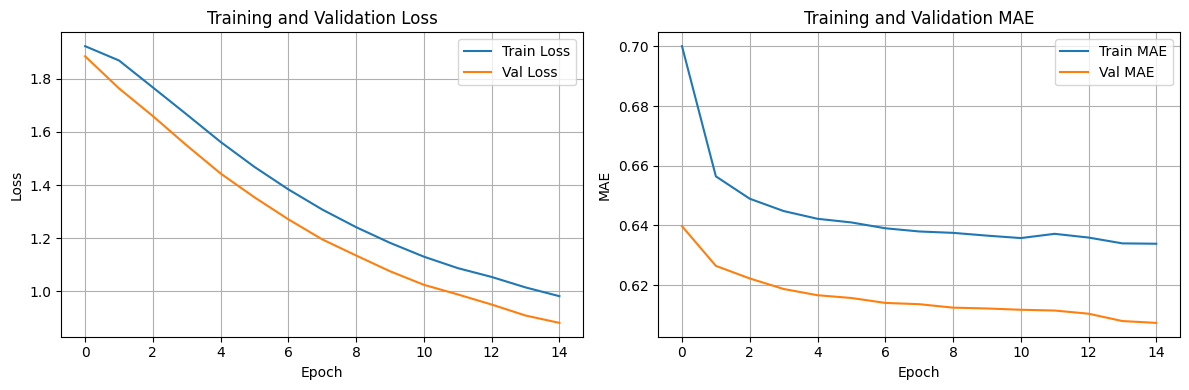

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['mae'], label='Train MAE')
plt.plot(history_hybrid.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [31]:
y_pred_scaled = model_hybrid.predict(X_test)
y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_true = output_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test, y_pred_scaled)

print(f'MAE: {mae}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step
MAE: 0.4201237599154835


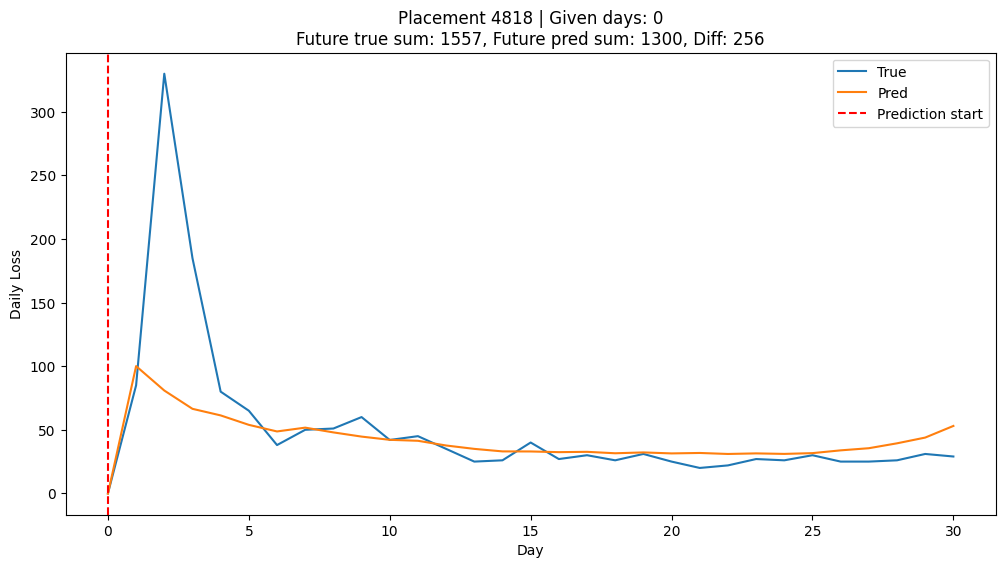

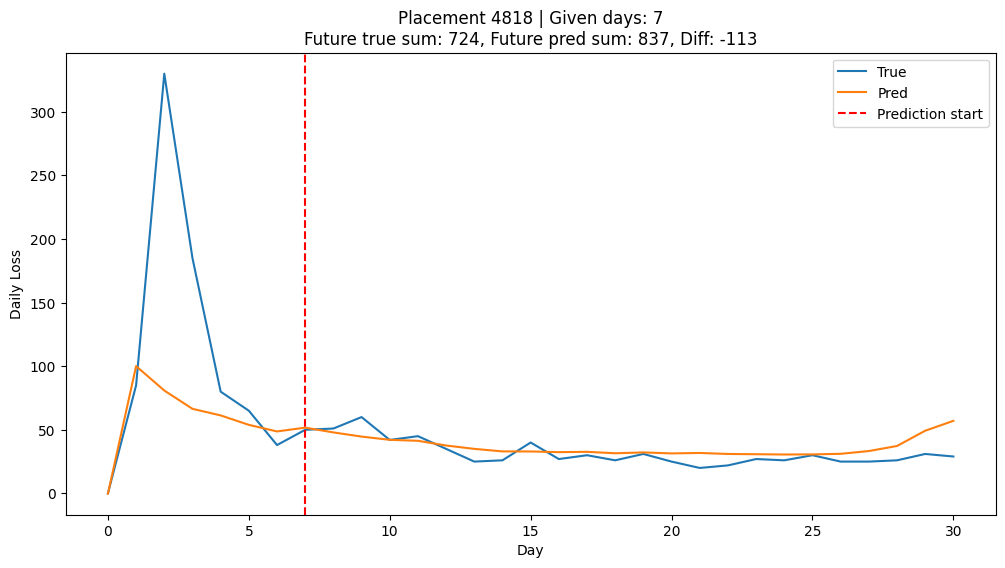

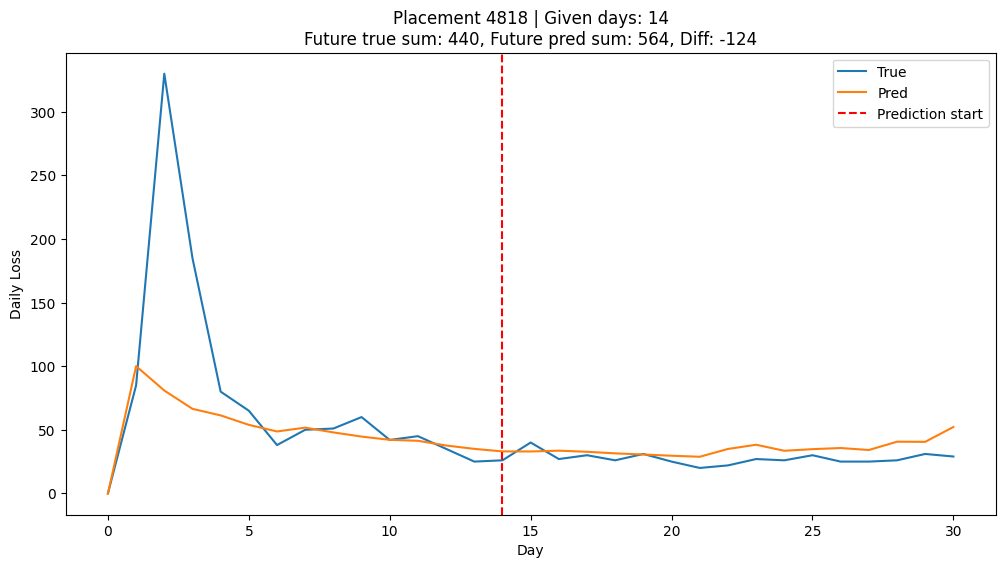

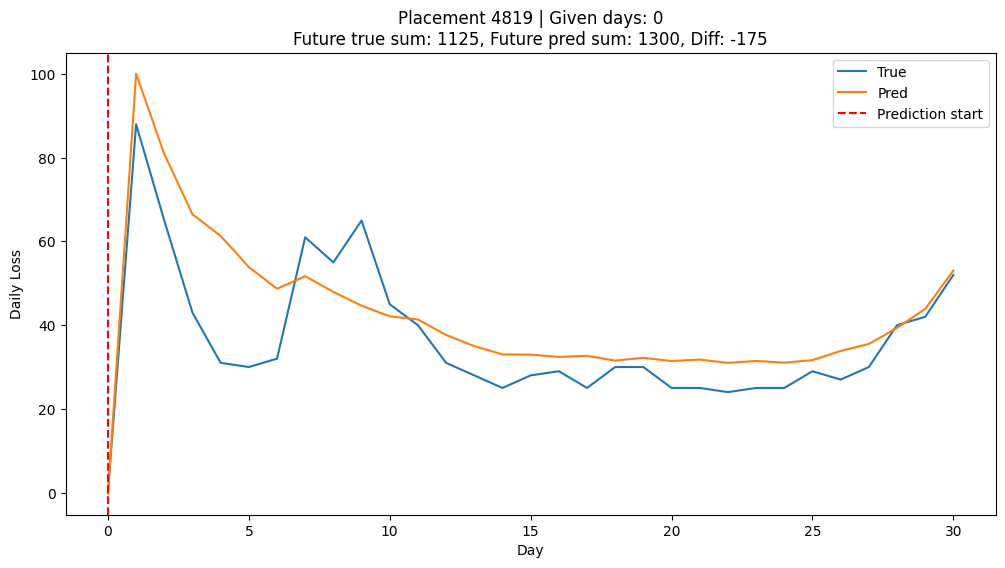

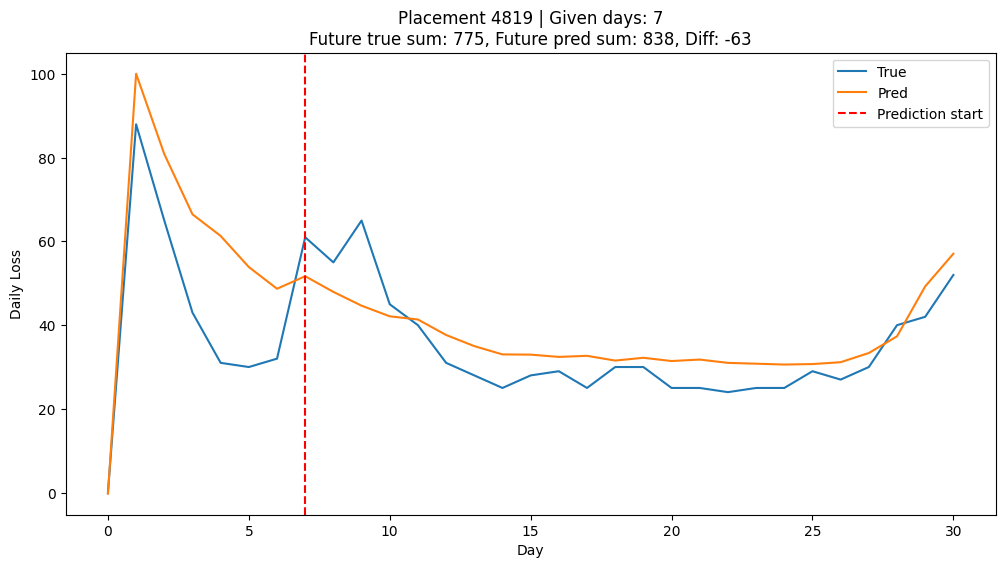

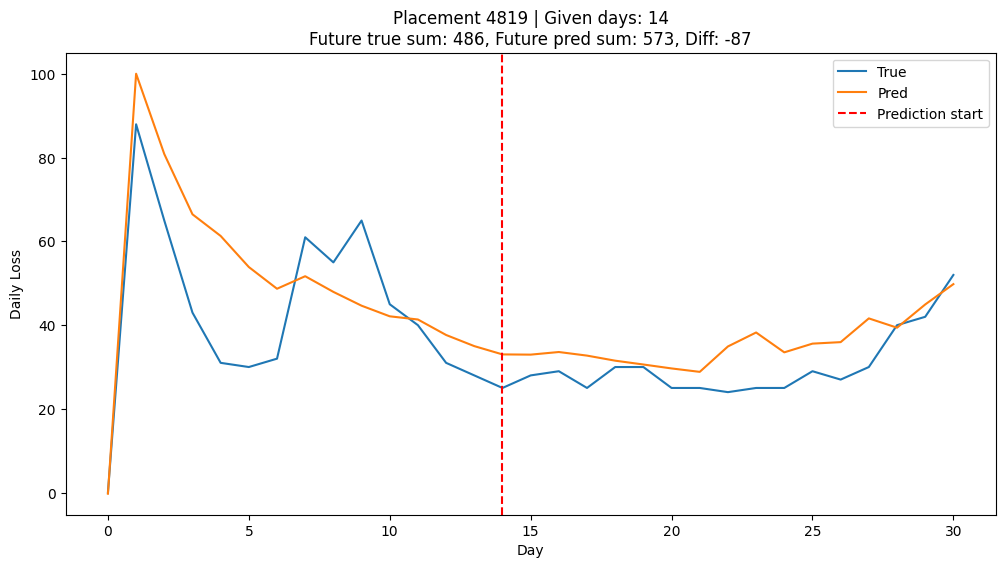

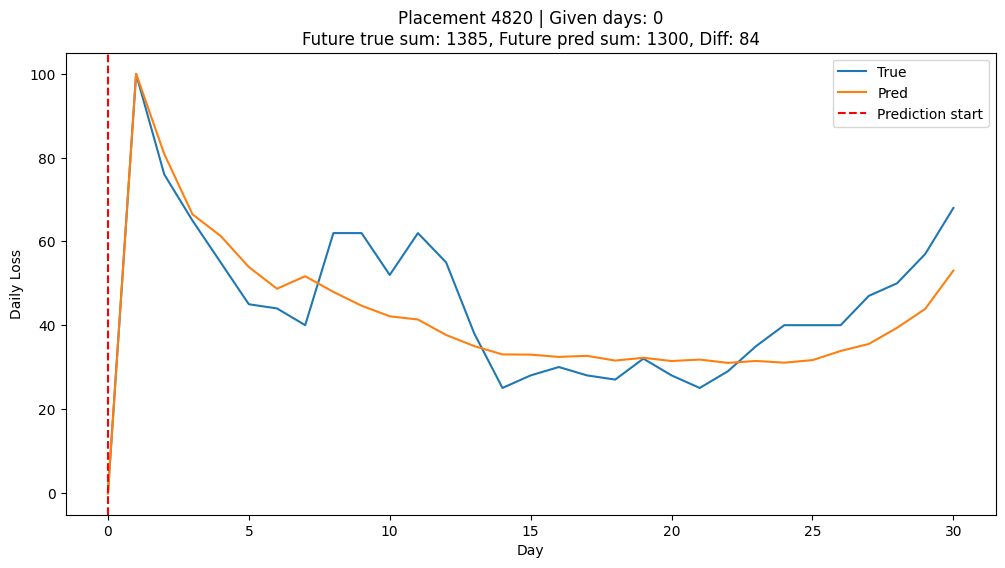

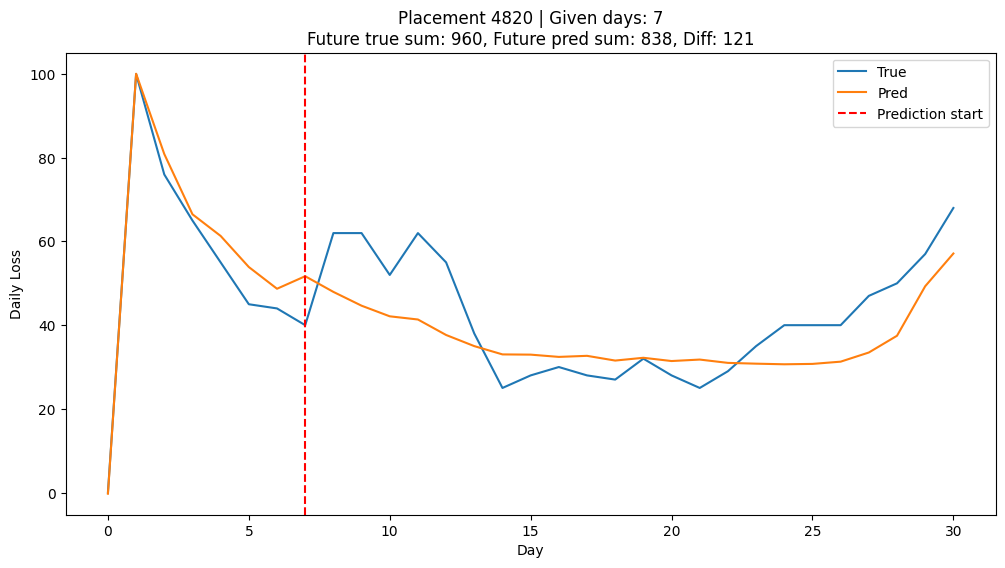

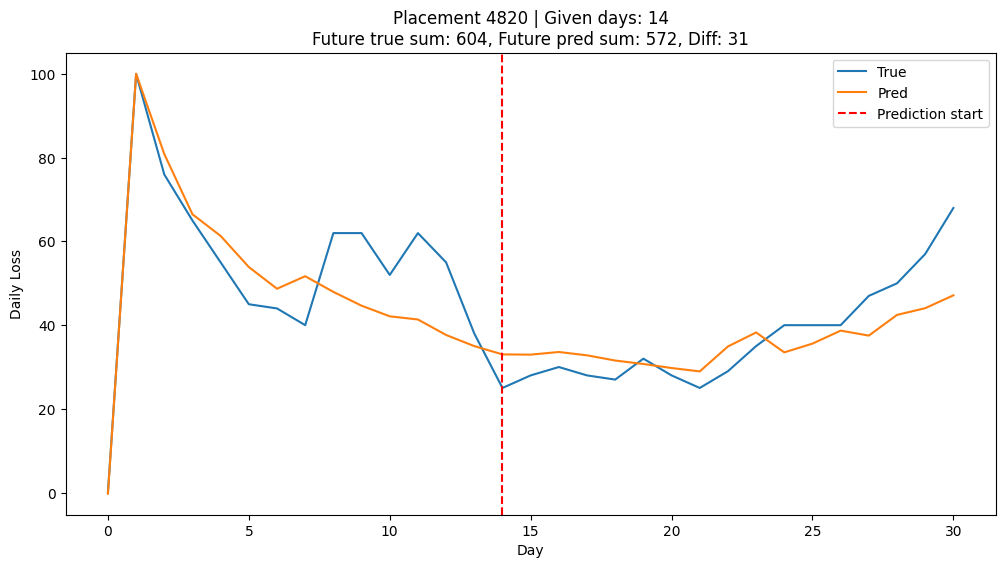

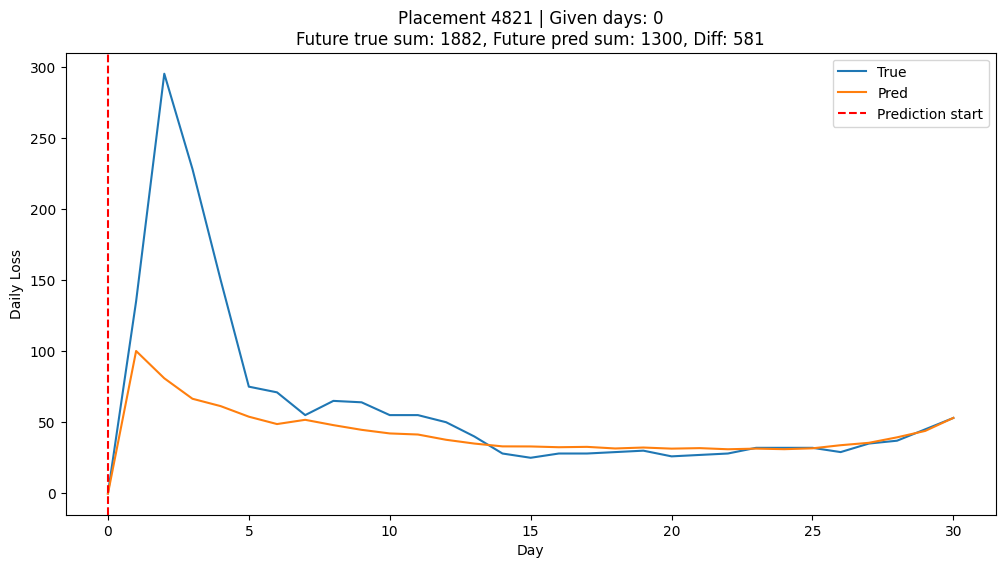

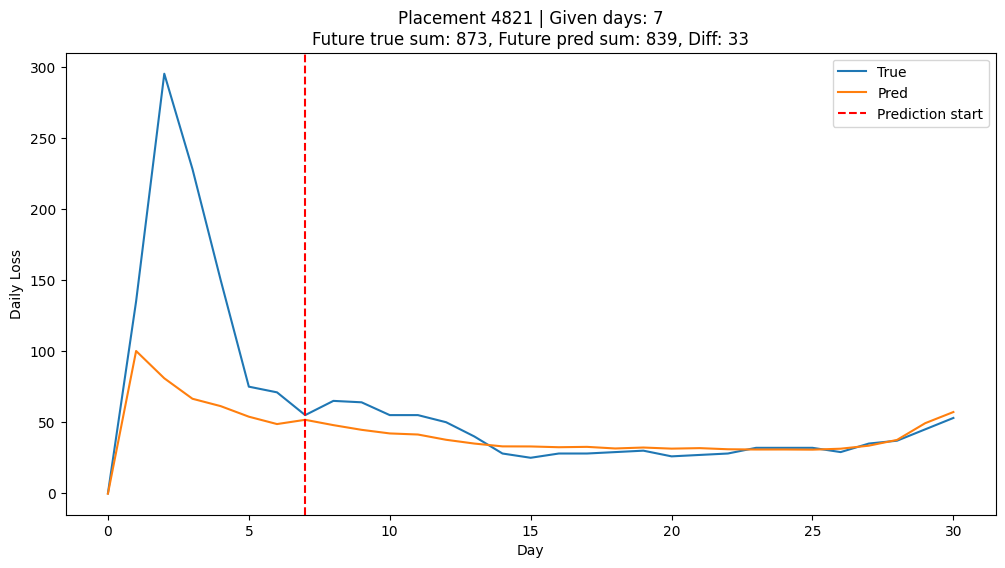

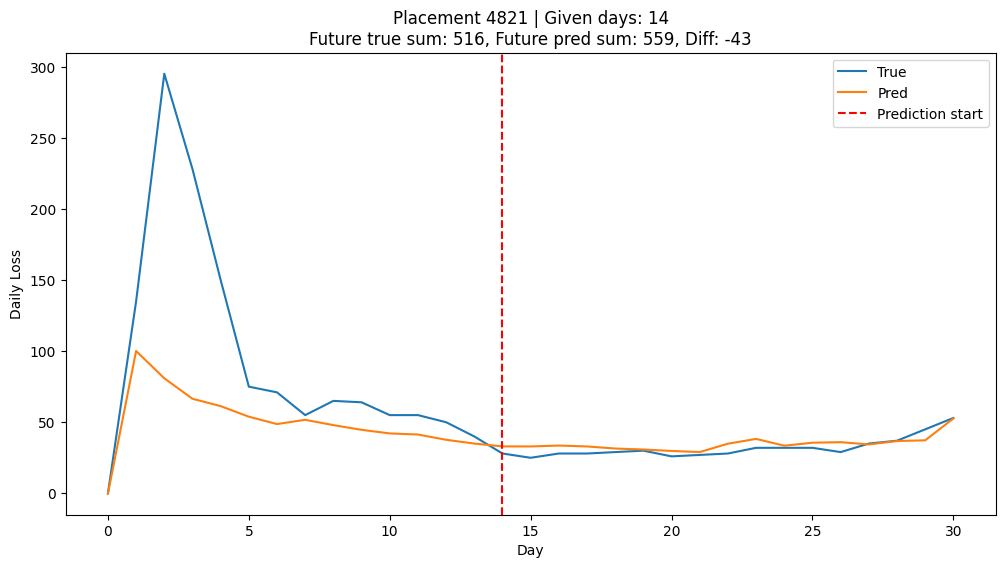

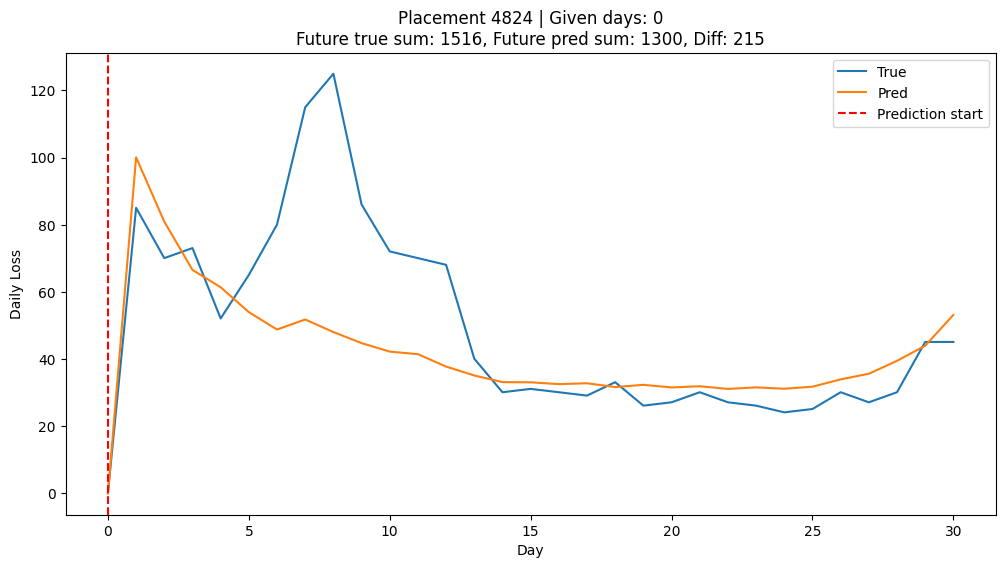

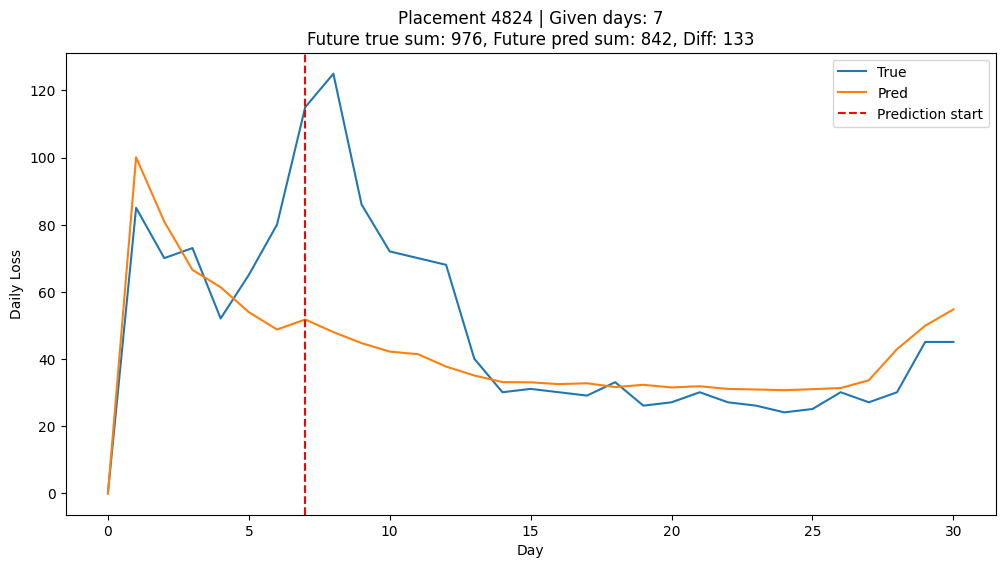

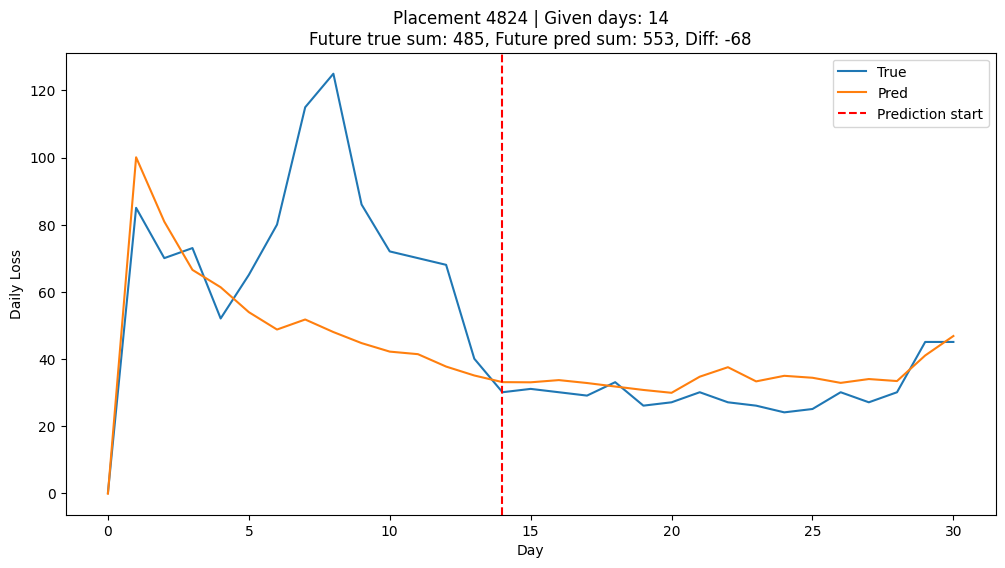

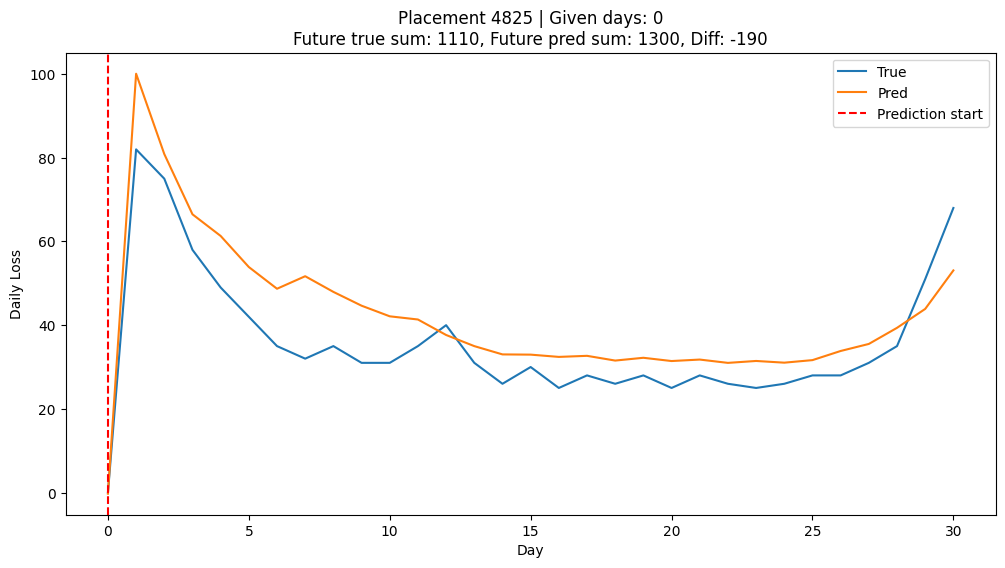

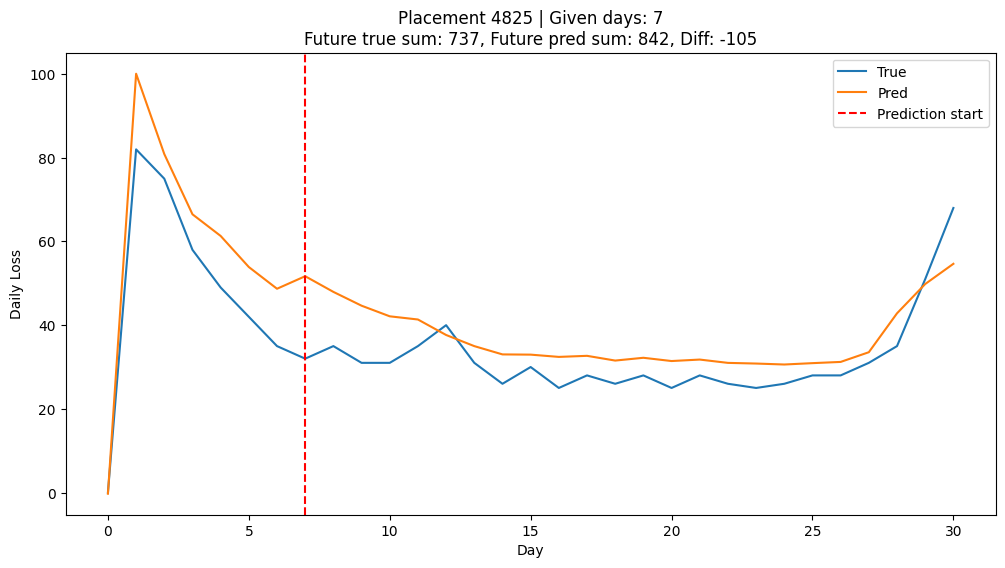

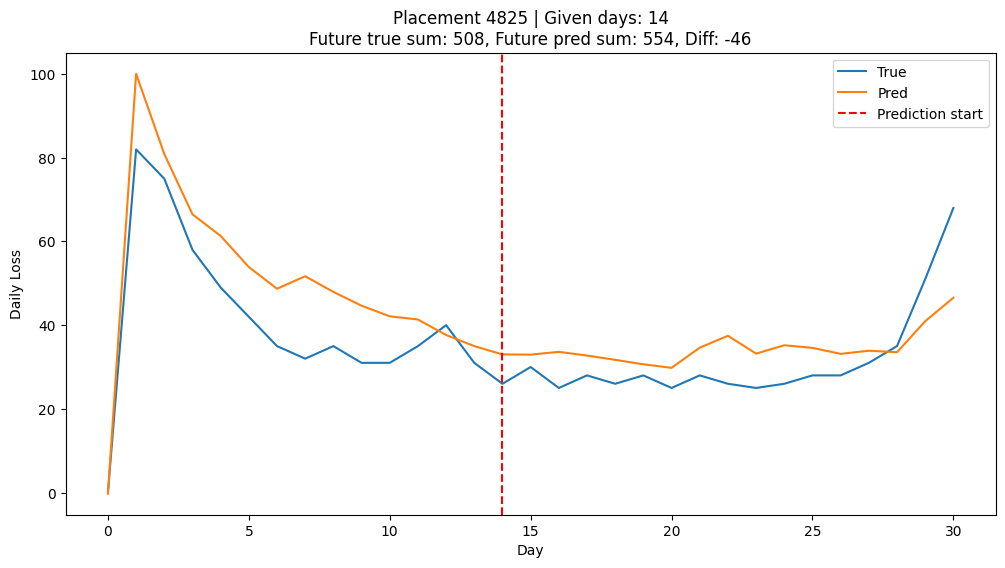

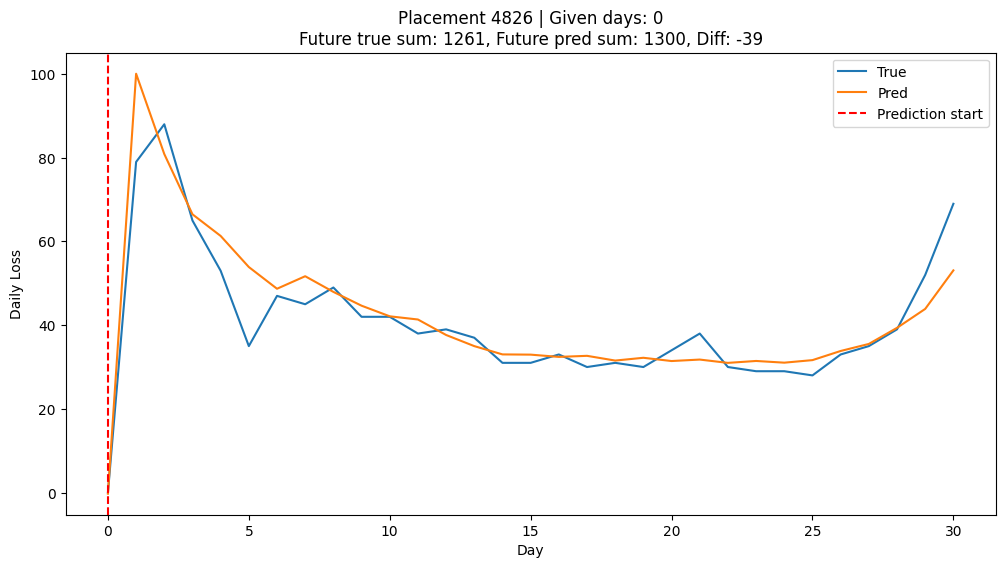

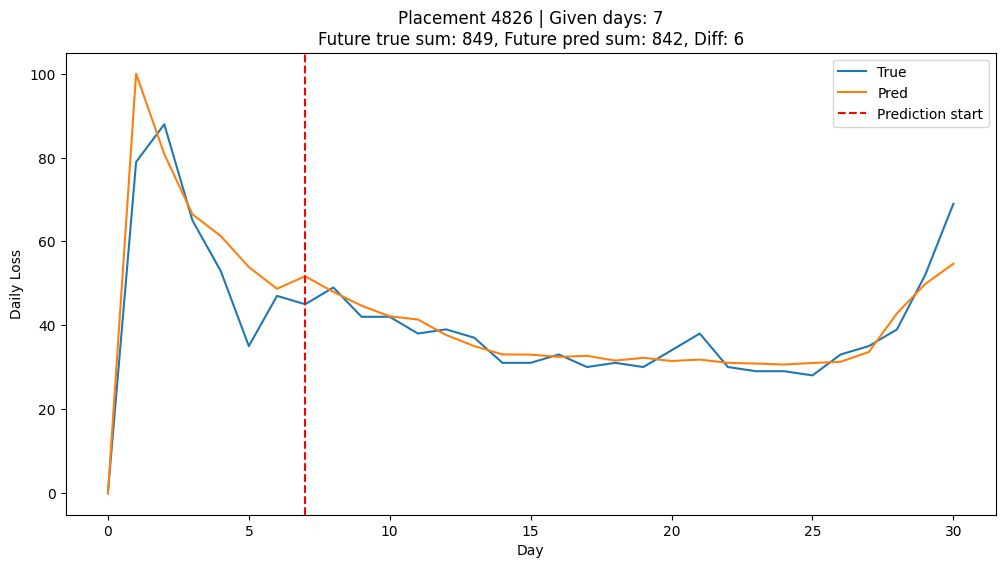

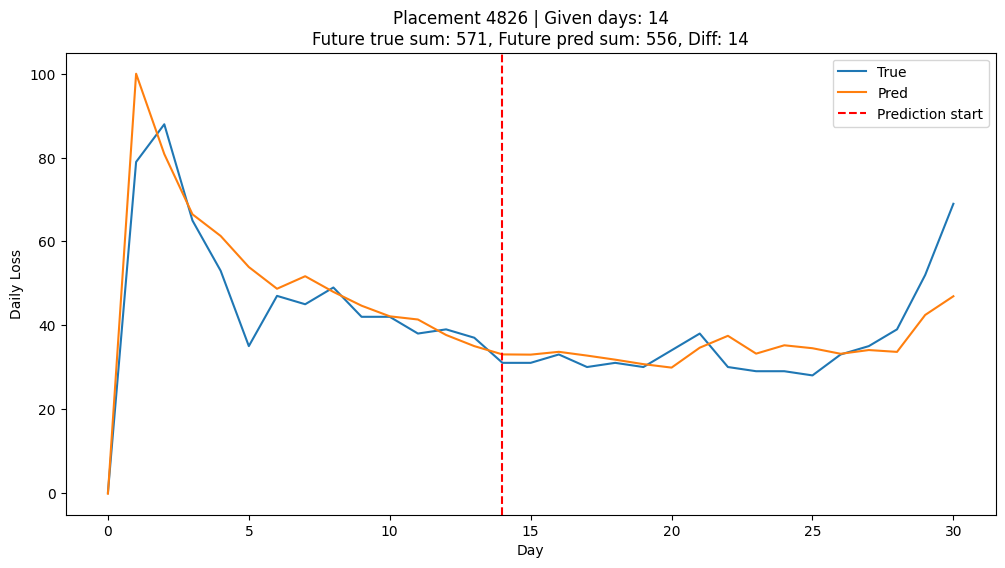

In [32]:
metrics = visualize_predictions_given_days_new_masked(
    placement_ids_to_show=test_placement_ids,
    df_test=df_test,
    model=model_hybrid,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    TARGET=TARGET,
    MAX_LEN=MAX_LEN,
    PAD_VALUE=PAD_VALUE,
    mask_test=mask_test,
    given_days=[0, 7,14]
)

In [33]:
h = []
for i in range(31):
  h.append(i)

score = horizon_weighted_mae(
    y_true=y_true,
    y_pred=y_pred,
    horizons=h
)
print("HW-NRMSE:", score)


HW-NRMSE: 0.18755200136902625


In [ ]:
# s = save_to_pdf(
#     placement_ids_to_show=placement_ids_to_show,
#     df_test=df_test,
#     model=model_hybrid,
#     input_scaler=input_scaler,
#     output_scaler=output_scaler,
#     numeric_features=numeric_features,
#     categorical_features=categorical_features,
#     TARGET=TARGET,
#     MAX_LEN=MAX_LEN,
#     PAD_VALUE=PAD_VALUE,
#     given_days=[0, 7, 14, 21, 28],
#     pdf_path="hybrid_VQ_TCN_model_1.pdf"
# )


# Model And Scaler Save

In [36]:
model_path = os.path.join(save_dir, "lstm_tcn_vq_model.keras") 
model_hybrid.save(model_path)
print(f"Model saved to {model_path}")


Model saved to /kaggle/working/production_model/lstm_tcn_vq_model.keras


In [38]:
input_scaler_path = os.path.join(save_dir, "input_scaler.joblib")
output_scaler_path = os.path.join(save_dir, "output_scaler.joblib")

joblib.dump(input_scaler, input_scaler_path)
joblib.dump(output_scaler, output_scaler_path)

print(f"Input scaler saved to {input_scaler_path}")
print(f"Output scaler saved to {output_scaler_path}")

Input scaler saved to /kaggle/working/production_model/input_scaler.joblib
Output scaler saved to /kaggle/working/production_model/output_scaler.joblib
